# TF Binding Prediction: Hyperparameter Tuning
Inhyeok Daniel Lee

April 18, 2025

## 1. Experiment Setup

The experiment aimed to find the optimal learning rate for the `BindingPredictorCNN` model. A grid search was performed over the following learning rates:

- `0.01`
- `0.001`
- `0.0001`

Other hyperparameters were kept constant:
- Optimizer: AdamW
- Weight Decay: 1e-5
- Batch Size: 64
- Number of Epochs: 5 (Reduced for faster testing)
- Early Stopping Patience: 10
- Validation Split: 0.2
- Model Architecture: Fixed (3 Residual Blocks, 32 Channels, Kernel Size 3, Dropout 0.2)

The primary metric for evaluation was `validation loss` (goal: minimize), with `validation Pearson R` (goal: maximize) as a secondary metric.

## 2. Core Code Architecture

In [ ]:
import os
import gzip
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from scipy.stats import pearsonr
import wandb

In [ ]:
# Data Configuration
DATA_DIR = '/Users/ihlee/Desktop/DL-Genomics/tf-binding-prediction/data'
SEQ_FILE = os.path.join(DATA_DIR, 'chr22_sequences.txt.gz')
SCORE_FILE = os.path.join(DATA_DIR, 'chr22_scores.txt.gz')

In [ ]:
# Helper Functions

def one_hot_encode(sequence):
    """Converts a DNA sequence string to a one-hot encoded tensor."""
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    seq_len = len(sequence)
    encoded = torch.zeros((4, seq_len), dtype=torch.float32)
    for i, base in enumerate(sequence.upper()):
        idx = mapping.get(base, -1)
        if idx != -1:
            encoded[idx, i] = 1.0
    return encoded

def calculate_pearsonr(preds, targets):
    """Calculates Pearson correlation, handling potential NaNs."""
    # Flatten tensors and convert to numpy
    preds_flat = preds.detach().cpu().numpy().flatten()
    targets_flat = targets.detach().cpu().numpy().flatten()

    # Remove NaNs or Infs if they somehow occur
    valid_indices = np.isfinite(preds_flat) & np.isfinite(targets_flat)
    preds_flat = preds_flat[valid_indices]
    targets_flat = targets_flat[valid_indices]

    if len(preds_flat) < 2: # Need at least 2 points for correlation
        return 0.0

    try:
        r, _ = pearsonr(preds_flat, targets_flat)
        return r if np.isfinite(r) else 0.0 # Return 0 if correlation is NaN/Inf
    except ValueError:
        return 0.0

In [ ]:
# Data Loading and Processing Class

class TFBindiingDataset(Dataset):
    def __init__(self, sequences, scores):
        self.sequences = sequences
        self.scores = scores
        # Pre-encode sequences if memory allows, otherwise encode on-the-fly in __getitem__
        self.encoded_sequences = [one_hot_encode(seq) for seq in sequences['sequence']]
        # Convert scores DataFrame columns to a list of tensors
        # Assuming scores columns match sequence order
        self.score_tensors = [torch.tensor(scores[col].values, dtype=torch.float32) for col in scores.columns]


    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        # Assuming sequence names in scores match sequence order/names
        # Find the corresponding score tensor - Assuming order matches
        if idx < len(self.score_tensors):
             score_vec = self.score_tensors[idx]
        else:
             raise IndexError(f"Score index {idx} out of bounds") 

        return self.encoded_sequences[idx], score_vec

In [ ]:
# Model Architecture Classes

class ResidualBlock(nn.Module):
    """Residual Block with LayerNorm."""
    def __init__(self, num_channels, kernel_size, dropout_rate):
        super().__init__()
        self.conv1 = nn.Conv1d(num_channels, num_channels, kernel_size,
                               stride=1, padding=kernel_size // 2, bias=False)
        self.norm1 = nn.LayerNorm([num_channels, 300]) # Normalize across channels and length
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.conv2 = nn.Conv1d(num_channels, num_channels, kernel_size,
                               stride=1, padding=kernel_size // 2, bias=False)
        self.norm2 = nn.LayerNorm([num_channels, 300])
        self.relu2 = nn.ReLU()

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu1(out)
        out = self.dropout(out)
        out = self.conv2(out)
        out = self.norm2(out)
        out += identity
        out = self.relu2(out)
        return out

class BindingPredictorCNN(nn.Module):
    def __init__(self, num_channels, num_blocks, kernel_size, dropout_rate):
        super().__init__()
        self.initial_conv = nn.Conv1d(4, num_channels, kernel_size,
                                      stride=1, padding=kernel_size // 2, bias=False)
        # Assuming input sequence length is 300, adjust if different
        self.initial_norm = nn.LayerNorm([num_channels, 300])
        self.initial_relu = nn.ReLU()

        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_channels, kernel_size, dropout_rate) for _ in range(num_blocks)]
        )

        self.final_conv = nn.Conv1d(num_channels, 1, kernel_size=1, stride=1, padding=0, bias=True)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
         for m in self.modules():
            if isinstance(m, nn.Conv1d):
                # He init for initial/block convs
                if m.out_channels == self.initial_conv.out_channels or m.in_channels == 4:
                     nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                # Default init might be okay for final 1x1 conv, or use Xavier
                elif m.out_channels == 1:
                     nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                     nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.initial_conv(x)
        x = self.initial_norm(x)
        x = self.initial_relu(x)
        x = self.res_blocks(x)
        x = self.final_conv(x)
        x = x.squeeze(1) # Remove channel dimension -> (Batch, 300)
        return x

## 3. Wandb Results

The following screenshot shows the results of the hyperparameter sweep, visualized on the Weights & Biases dashboard.

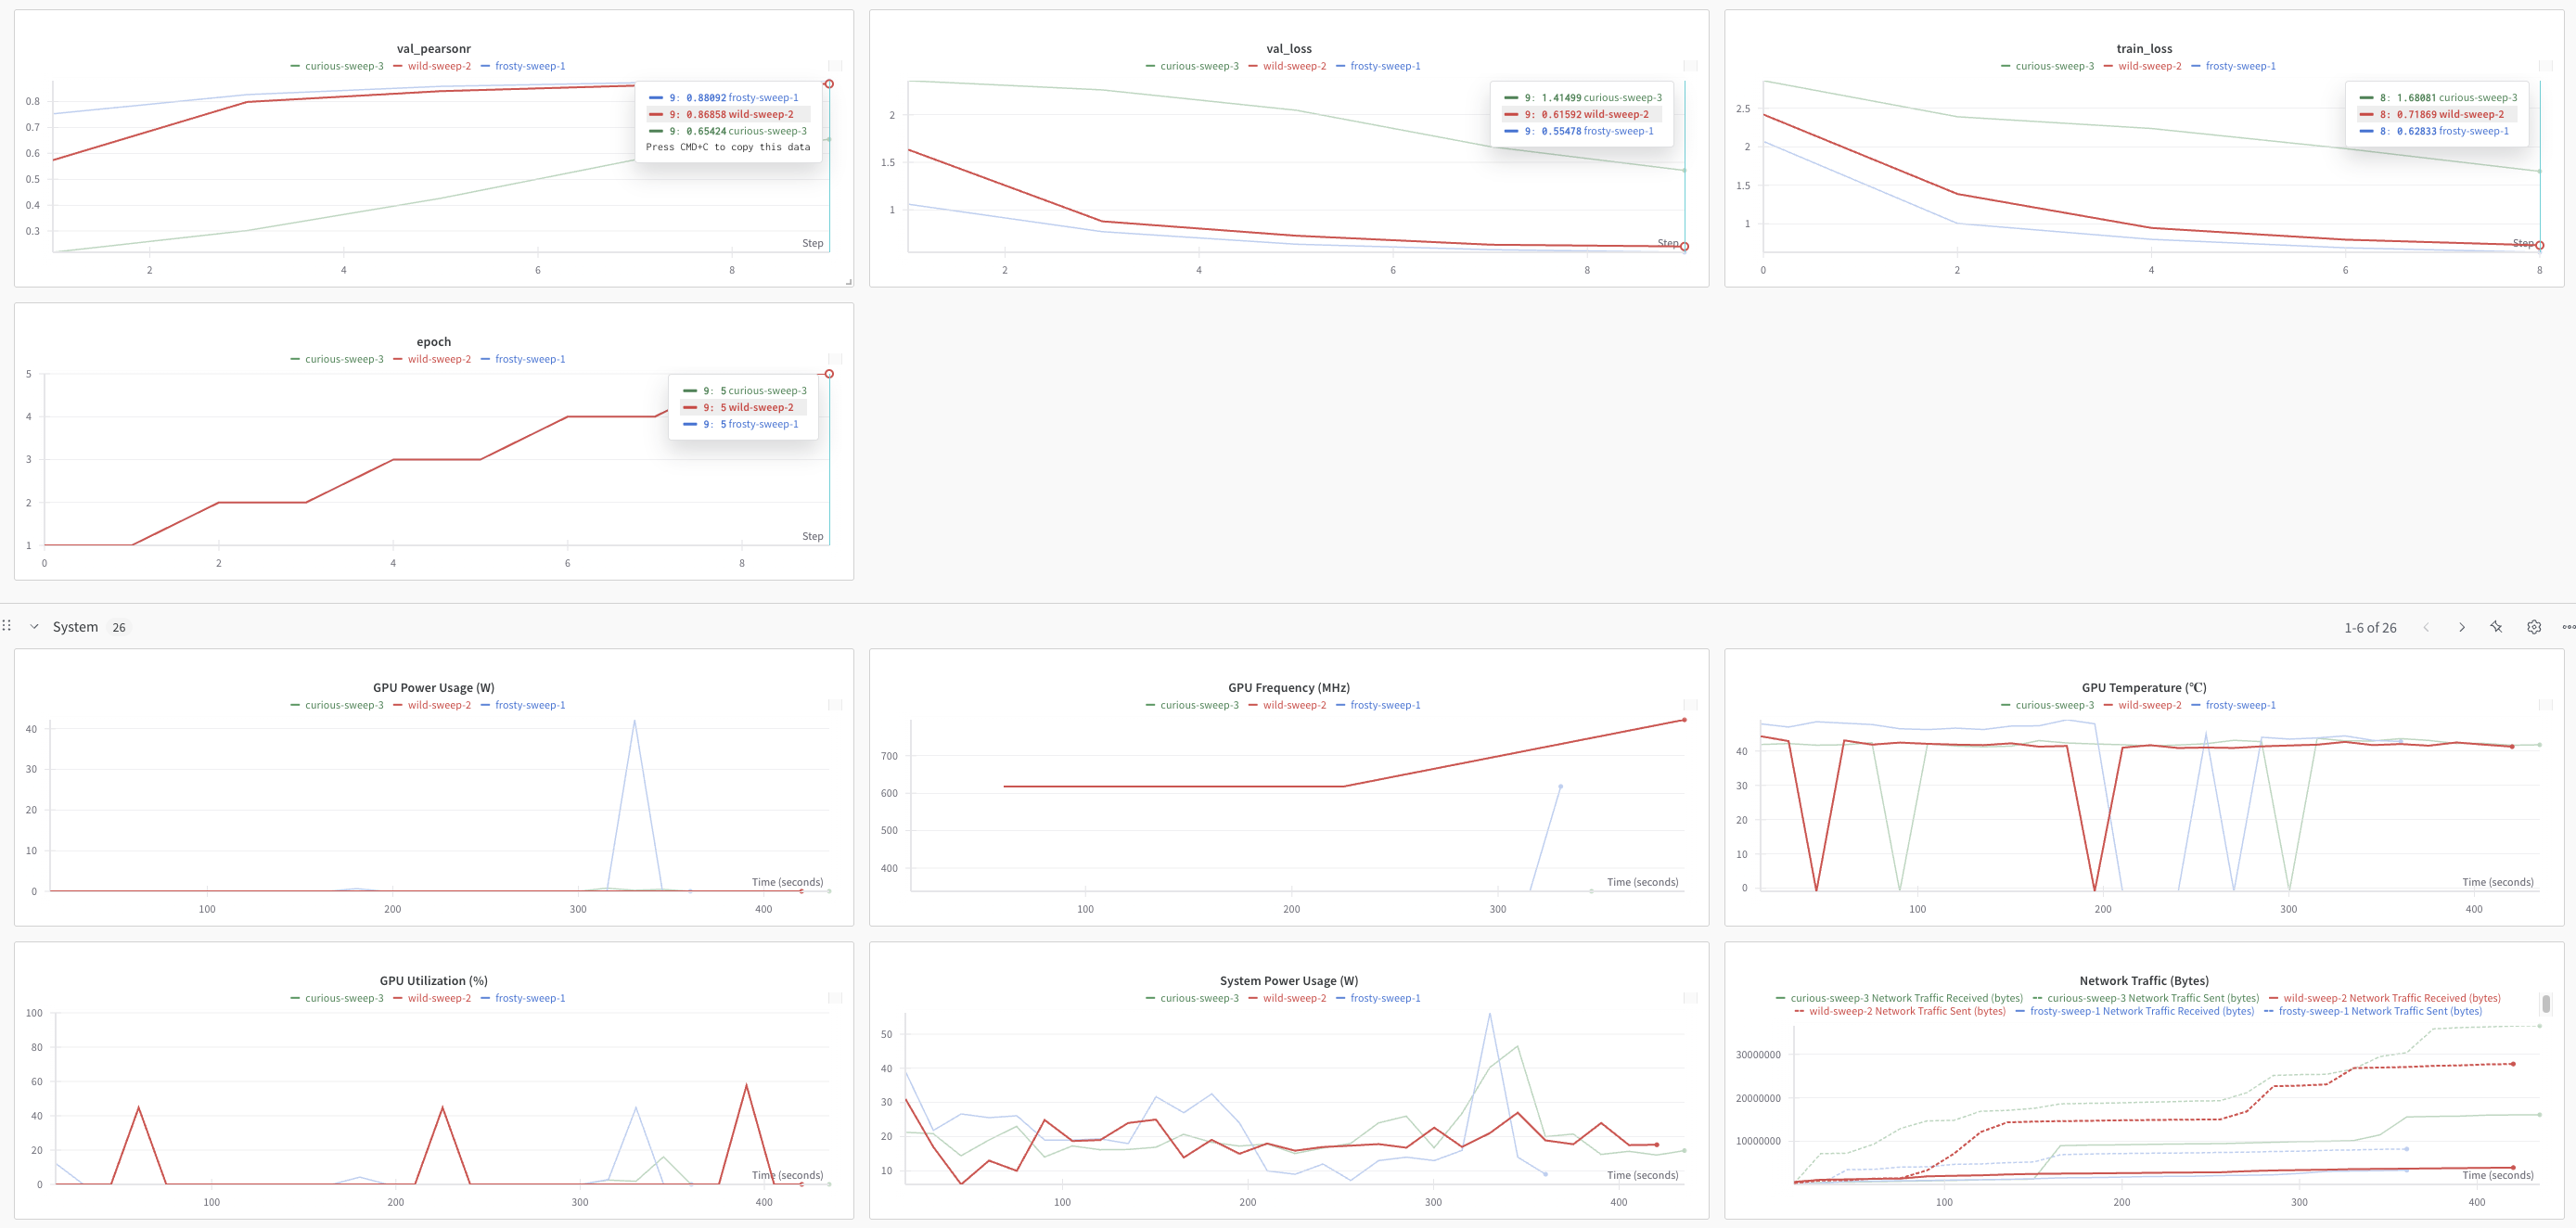

## 4. Interpretation

The performance of the three learning rates after 5 epochs gives:

| Learning Rate |     Validation Loss   |    Validation Pearson R    |
|---------------|-----------------------|----------------------------|
| 0.01          | ~0.5548               | ~0.8809                    |
| 0.001         | ~0.6159               | ~0.8686                    |
| 0.0001        | ~1.4150               | ~0.6542                    |


- **Learning Rate 0.01:** Achieved the lowest validation loss and the highest Pearson correlation coefficient within the 5 epochs run. This suggests that a higher learning rate leads to faster convergence for this model and dataset, at least initially.
- **Learning Rate 0.001:** Performed reasonably well, ending with slightly higher loss and lower correlation than the 0.01 run.
- **Learning Rate 0.0001:** Showed significantly slower convergence. This learning rate is likely too small for efficient training in this setup.

- For the limited 5-epoch run, the learning rate of **0.01** yielded the best results. However, it's important to consider potential overfitting with higher learning rates over longer training periods. The original script was configured for 100 epochs with early stopping (patience=10). Running the sweep for more epochs would provide a more definitive answer about the optimal learning rate and whether the 0.01 rate maintains its lead or starts to overfit compared to 0.001.